/Users/shahargino/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


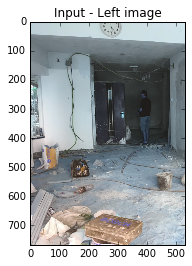

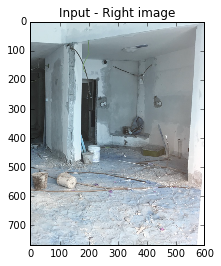

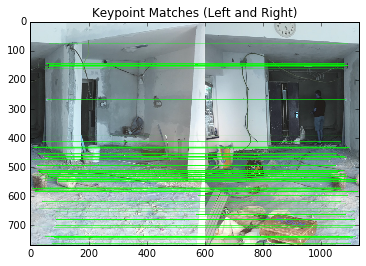

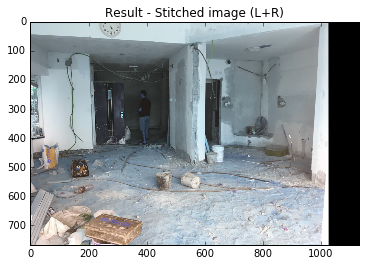

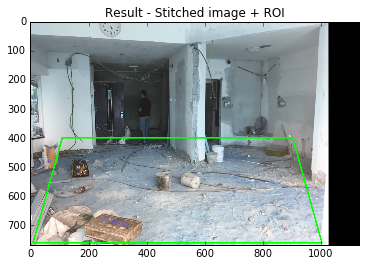

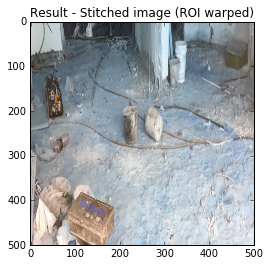

In [1]:
#!/usr/bin/python
# (c) Shahar Gino, November-2017, sgino209@gmail.com
#
# The stitching algorithm requires four steps:
# (1) Detecting keypoints and extracting local invariant descriptors (SIRF)
# (2) Matching descriptors between images (k-NN with k=2 + David Lowe's ratio test)
# (3) Applying RANSAC to estimate the homography transform (3x3 matrix)
# (4) Applying a warping transformation using the homography matrix
#
# References:
# (1) https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching
# (2) https://www.pyimagesearch.com/2016/01/25/real-time-panorama-and-image-stitching-with-opencv
# (3) https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6

%matplotlib inline
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
%pylab inline

class Stitcher:

    # ------------------------------------------------------------------------------------------------

    def __init__(self):
        """
        Constructor: mainly determines if we are using OpenCV v3.X, Since there are major differences
        in how OpenCV 2.4 and OpenCV 3 handle keypoint detection and local invariant descriptors.
        This information is applied in detectAndDescribe() method.
        """

        self.isv3 = imutils.is_cv3()

    # ------------------------------------------------------------------------------------------------

    def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        """
        Stitches 2 images into a single panorama image.

        Mandatory argument:
        (-) images --> list of 2 images that are going to be stitched together to form the panorama
                       Important: images are expected to be supplied in left-to-right order.

        Optional arguments:
        (-) ratio --> used for David Lowe's ratio test when matching features (typically between [0.7,0.8])
        (-) reprojThresh --> the maximum pixel "wiggle room" allowed by the RANSAC algorithm
        (-) showMatches --> a boolean used to indicate if the keypoint matches should be visualized or not
        """

        # Unpack the images, then detect keypoints and extract local invariant descriptors (SIFT) from them:
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # Match features between the two images (RANSAC):
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

        # If the match is None, then there aren't enough matched keypoints to create a panorama:
        if M is None:
            return None

        # Otherwise, apply a perspective warp to stitch the images together:
        (matches, H, status) = M
        imOut_shape = (imageA.shape[1] + imageB.shape[1], imageA.shape[0])
        result = cv2.warpPerspective(imageA,       # the image we want to warp (the 'right' image)
                                     H,            # the homography, 3x3 matrix
                                     imOut_shape)  # the shape of the output image
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # Check to see if the keypoint matches should be visualized:
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)

            # return a tuple of the stitched image and the visualization:
            return (result, vis)

        # return the stitched image:
        return result

    # ------------------------------------------------------------------------------------------------

    def detectAndDescribe(self, image):
        """
        Detects keypoints and extracts local invariant descriptors for a given image.
        A Difference of Gaussian (DoG) keypoint detector and the SIFT feature extractor are applied
        """

        # Convert the image to grayscale:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Check to see if we are using OpenCV 3.X:
        if self.isv3:
            # Detect and extract features from the image:
            descriptor = cv2.xfeatures2d.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)

        # Otherwise, we are using OpenCV 2.4.X:
        else:
            # Detect keypoints in the image:
            detector = cv2.FeatureDetector_create("SIFT")
            kps = detector.detect(gray)

            # Extract features from the image:
            extractor = cv2.DescriptorExtractor_create("SIFT")
            (kps, features) = extractor.compute(gray, kps)

        # Convert the keypoints from KeyPoint objects to NumPy arrays:
        kps = np.float32([kp.pt for kp in kps])

        # Return a tuple of keypoints and features:
        return (kps, features)

    # ------------------------------------------------------------------------------------------------

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        """
        Matching features together is obtained by looping over the descriptors from both images,
        compute the distances, and find the smallest distance for each pair of descriptors.
        It returns the matching features (SIRF), the corresponding homography transform (3x3 matrix)
        and a status list provided by the homography calculation.

        Expected arguments:
        (-) kpsA --> the keypoints associated with the first image
        (-) kpsB --> the keypoints associated with the second image
        (-) featuresA --> the feature vectors associated with the first image
        (-) featuresB --> the feature vectors associated with the second image
        (-) ratio --> David Lowe's ratio test variable, typically in the range of [0.7,0.8]
        (-) reprojThresh --> RANSAC re-projection threshold
        """

        # Compute the raw matches and initialize the list of actual matches:
        # 'BruteForce' --> exhaustively compute the Euclidean distance between all feature vectors from
        #                  both images and find the pairs of descriptors that have the smallest distance.
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)  # k-NN matching with k=2 (the top two matches for each
        matches = []                                            #                         feature vector are returned)

        # Loop over the 2 raw matches (David Lowe's ratio test for false-positive match pruning):
        for m in rawMatches:
            # Ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # Computing an Homography between the two sets of keypoints (requires at least 4 matches, although for a
        # more reliable homography estimation, we should have substantially more than just four matched points):
        if len(matches) > 4:

            # Construct the two sets of points:
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # Compute the homography between the two sets of points:
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # Return the matches along with the homograpy matrix and status of each matched point:
            return (matches, H, status)

        # Otherwise, no homograpy could be computed:
        return None

    # ------------------------------------------------------------------------------------------------

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        """
        Auxiliary method, used to visualize keypoint correspondences between two images.
        It visualizes the "inlier" keypoints by drawing a straight lines from each keypoint N in the first
        image to its corresponding keypoint M in the second image.
        The method requires two original images (imageA,imageB), the set of keypoints associated with each
        image (kpsA,kpsB), the initial matches after applying Lowe's ratio test (matches), and finally the
        status list provided by the homography calculation (status).
        """

        # Initialize the output visualization image:
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # Loop over the matches:
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # Only process the match if the keypoint was successfully matched:
            if s == 1:
                # Draw the match:
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis

# ==================================================================================================================
if __name__ == "__main__":

    # Load the two images:
    imageA = cv2.imread("left.jpg")
    imageB = cv2.imread("right.jpg")
        
    # Stitch the images together to create a panorama:
    stitcher = Stitcher()
    (result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

    # Warp onto a rectangle ("birds eye" view):
    result_roi = result.copy() #768,1131

    roi_polygon = [[110, 400],   # top-left
                   [900, 400],   # top-right
                   [1000, 760],  # bottom-right
                   [10, 760]]    # bottom-left

    rect = np.zeros((4, 2), dtype="float32")
    for k in range(len(roi_polygon)):
        rect[k] = roi_polygon[k]

    # Construct our destination points which will be used to map the screen to a top-down, "birds eye" view:
    (W, H) = (500,500)
    dst = np.array([[0, 0], [W-1, 0], [W-1, H-1], [0, H-1]], dtype="float32")

    # Calculate the perspective transform matrix and warp the perspective to grab the screen:
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(result, M, (W,H))

    # Show the images:
    pts = np.array(roi_polygon, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(result_roi, [pts], True, (0, 255, 0), 3)
    
    plt.imshow(imageA);      plt.title('Input - Left image');                    plt.show()
    plt.imshow(imageB);      plt.title('Input - Right image');                   plt.show()
    plt.imshow(vis);         plt.title('Keypoint Matches (Left and Right)');     plt.show()
    plt.imshow(result);      plt.title('Result - Stitched image (L+R)');         plt.show()
    plt.imshow(result_roi);  plt.title('Result - Stitched image + ROI');         plt.show()
    plt.imshow(warp);        plt.title('Result - Stitched image (ROI warped)');  plt.show()
